<a href="https://colab.research.google.com/github/YYZhang2025/AI-Notebooks/blob/main/cuda_matmul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on CUDA mode lecture03:

- Original Notebooks: https://github.com/anmolgupt/cuda_mode_lectures/blob/main/lecture_003/pmpp.ipynb
- Lecture Video: https://www.youtube.com/watch?v=4sgKnKbR-WE

In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
!wget https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/10/Demon-Slayer---Rengoku-laughing.jpg -O image.png

--2025-08-06 05:14:20--  https://static1.cbrimages.com/wordpress/wp-content/uploads/2022/10/Demon-Slayer---Rengoku-laughing.jpg
Resolving static1.cbrimages.com (static1.cbrimages.com)... 138.199.46.68, 2400:52e0:1500::868:1
Connecting to static1.cbrimages.com (static1.cbrimages.com)|138.199.46.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63270 (62K) [image/jpeg]
Saving to: ‘image.png’

image.png           100%[===================>]  61.79K  --.-KB/s    in 0s      

2025-08-06 05:14:20 (307 MB/s) - ‘image.png’ saved [63270/63270]



In [3]:
img = io.read_image('image.png')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 600, 1200])


tensor([[[2, 2, 2, 2],
         [2, 2, 2, 2],
         [2, 2, 2, 2]],

        [[2, 2, 2, 2],
         [2, 2, 2, 2],
         [2, 2, 2, 2]]], dtype=torch.uint8)

In [4]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

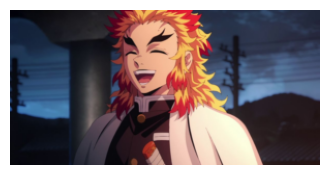

In [5]:
img2 = tvf.resize(img, 150, antialias=True)
show_img(img2)

In [6]:
def rgb2grey_py(x):
    c, h , w = x.shape
    n = h * w # if the offset for the different channels
    x = x.flatten()

    res = torch.empty(n, dtype = x.dtype, device = x.device)
    for i in range(n):
        res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

    return res.view(h, w)

In [7]:
%%time
img_g = rgb2grey_py(img2)

CPU times: user 2.06 s, sys: 1.24 ms, total: 2.06 s
Wall time: 2.09 s


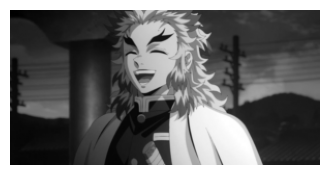

In [8]:
show_img(img_g, cmap='gray')

In [9]:
def run_kernel(f, times, *args):
    for i in range(times):
        f(i, *args)

In [10]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [11]:
def rgb2grey_pyk(x):
    c, h, w = x.shape
    n = h * w
    x = x.flatten()
    res = torch.empty(n, dtype = x.dtype, device = x.device)

    run_kernel(rgb2grey_k, n , x, res, n)
    return res.view(h, w)

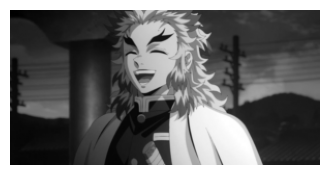

In [12]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

In [13]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads):
            f(i, j , threads, *args)

In [14]:
def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx * blockdim + threadidx # In which thread
    if i < n:
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [15]:
def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)

    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)

    return res.view(h,w)

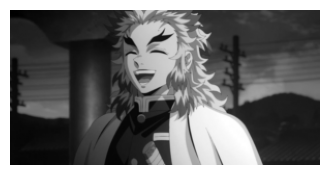

In [16]:
img_g = rgb2grey_pybk(img2)
show_img(img_g, cmap='gray')

## CUDA

In [51]:
import shutil
import os
import torch.utils.cpp_extension

cache_dir = torch.utils.cpp_extension.get_default_build_root()
ext_name = "inline_ext"
ext_dir = os.path.join(cache_dir, f"py311_cu124", ext_name)

if os.path.exists(ext_dir):
    print(f"Removing existing extension directory: {ext_dir}")
    shutil.rmtree(ext_dir)

Removing existing extension directory: /root/.cache/torch_extensions/py311_cu124/inline_ext


In [52]:
!pip install ninja

In [53]:
!rm -rf ~/.cache/torch_extensions/py311_cu124/inline_ext

In [54]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [55]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [56]:
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [62]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose = False, force= True):
    return load_inline(
        cuda_sources=[cuda_src],
        cpp_sources=[cpp_src],
        functions = funcs,
        extra_cuda_cflags=["-O2"] if opt else [],
        verbose=verbose,
        name="inline_ext",
    )

In [63]:
cuda_begin = r"""
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
"""

In [68]:
cuda_src= cuda_begin + r"""
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n){
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n){
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
    CHECK_INPUT(input);

    int h = input.size(1);
    int w = input.size(2);

    printf("h*w: %d*%d\n", h, w);

    auto output = torch::empty({h, w}, input.options());
    int threads = 256;

    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);

    C10_CUDA_KERNEL_LAUNCH_CHECK();

    return output;
}
"""

In [69]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [70]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True, force=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_ext have changed. Bumping to version 1 and re-building as inline_ext_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_ext/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_ext_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/i

Loading extension module inline_ext_v1...


In [71]:
[o for o in dir(module) if o[0]!='_'] # Check available methods

['rgb_to_grayscale']

In [72]:
imgc = img.contiguous().cuda() # Make sure data is contiguous

In [73]:
%%time
res = module.rgb_to_grayscale(imgc).cpu()

h,w = res.shape
h,w,h*w

CPU times: user 2.02 ms, sys: 29 µs, total: 2.05 ms
Wall time: 2.67 ms


(600, 1200, 720000)

h*w: 600*1200


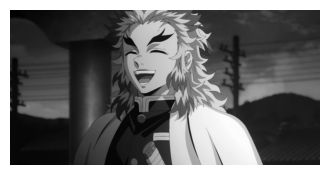

In [74]:
show_img(res, cmap='gray')

## CUDA Matrix Multiplication

In [75]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [76]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [77]:
with gzip.open(path_gz, 'rb') as f:
     ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [78]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

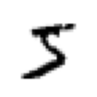

In [80]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [81]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

In [82]:
m1 = x_valid[:5] # 5 images
m2 = weights # weight
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

$$
y = \mathrm{x} \mathrm{W}
$$

In [89]:
ar,ac = m1.shape # n_rows * n_cols
br,bc = m2.shape
t1 = torch.zeros(ar, bc)
t1.shape # result

torch.Size([5, 10])

In [90]:
for i in range(ar): # number of data points:  5
    for j in range(bc):  # number of classes: 10
        for k in range(ac): # number of entry in each data point
            t1[i, j] += m1[i, k] * m2[k, j]

t1.shape

torch.Size([5, 10])

In [91]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [92]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [95]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c =torch.zeros(ar, ac)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]

    return c

In [96]:
%time
_=matmul(m1, m2)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.58 µs


In [97]:
ar*bc*ac

39200

In [98]:
from types import SimpleNamespace as ns

In [99]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x):

                    f(ns(x=i1,y=i0), ns(x=j1,y=j0), threads, *args)

In [100]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w):
        return

    o = 0.0
    for i in range(k):
        o += m[r*k+i] * n[i*w+c]

    out[r*w+c] = o

In [101]:
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Size mismatch!"

    output = torch.zeros(h, w, dtype=m.dtype)

    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))

    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)

    return output

In [102]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

In [103]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h) {
    int c = blockIdx.x*blockDim.x + threadIdx.x;
    int r = blockIdx.y*blockDim.y + threadIdx.y;

    if (c<w && r<h) {
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h,w}, input.options());
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w, h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [104]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


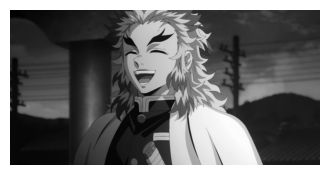

In [105]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')

In [106]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");

    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));

    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);

    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [107]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [108]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [109]:
torch.isclose(t1, module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [110]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 456 µs, sys: 0 ns, total: 456 µs
Wall time: 464 µs


torch.Size([5, 10])

In [111]:

torch.isclose(t1,(m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [112]:
%timeit -n 10 _=(m1c@m2c).cpu()

88.6 µs ± 28.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)

    for i in range(ar):
        c[i] = (a[i,:,None] * b).sum(dim=0)

    return c

In [114]:
torch.isclose(t1,matmul(m1, m2)).all()

tensor(True)

In [115]:
%time _=matmul(m1, m2)

CPU times: user 543 µs, sys: 0 ns, total: 543 µs
Wall time: 552 µs


In [116]:
m1 = x_train
tr = matmul(m1, m2)

tr.shape

torch.Size([50000, 10])

In [117]:
%time _=matmul(m1, m2)

CPU times: user 1.4 s, sys: 4.85 ms, total: 1.4 s
Wall time: 1.51 s


In [118]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000